# Problem 4: Multi-Head Attention - Interactive Notebook

This notebook explores how multiple attention heads capture different patterns.

## Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import your solution
# When finished, uncomment the following sentence and import your own solution
from solution import MultiHeadAttention
# from problem import MultiHeadAttention

# Set random seed
torch.manual_seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup complete!")

Setup complete!


## Create Multi-Head Attention Module

In [2]:
# Create multi-head attention
n_embd = 768
n_head = 12  # GPT-2 small configuration

mha = MultiHeadAttention(n_embd=n_embd, n_head=n_head, dropout=0.0)
mha.eval()

print(mha)
print(f"\nConfiguration:")
print(f"  Embedding dimension: {n_embd}")
print(f"  Number of heads: {n_head}")
print(f"  Head dimension: {n_embd // n_head}")
print(f"\nTotal parameters: {sum(p.numel() for p in mha.parameters()):,}")

MultiHeadAttention(
  (c_attn): Linear(in_features=768, out_features=2304, bias=True)
  (c_proj): Linear(in_features=768, out_features=768, bias=True)
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
)

Configuration:
  Embedding dimension: 768
  Number of heads: 12
  Head dimension: 64

Total parameters: 2,362,368


## Test Forward Pass

In [3]:
# Test forward pass
batch_size = 2
seq_len = 10
x = torch.randn(batch_size, seq_len, n_embd)

print(f"Input shape: {x.shape}")

with torch.no_grad():
    output = mha(x)

print(f"Output shape: {output.shape}")
print(f"✓ Shape preserved: {x.shape} → {output.shape}")

Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])
✓ Shape preserved: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])


## Visualize Attention Patterns for Each Head

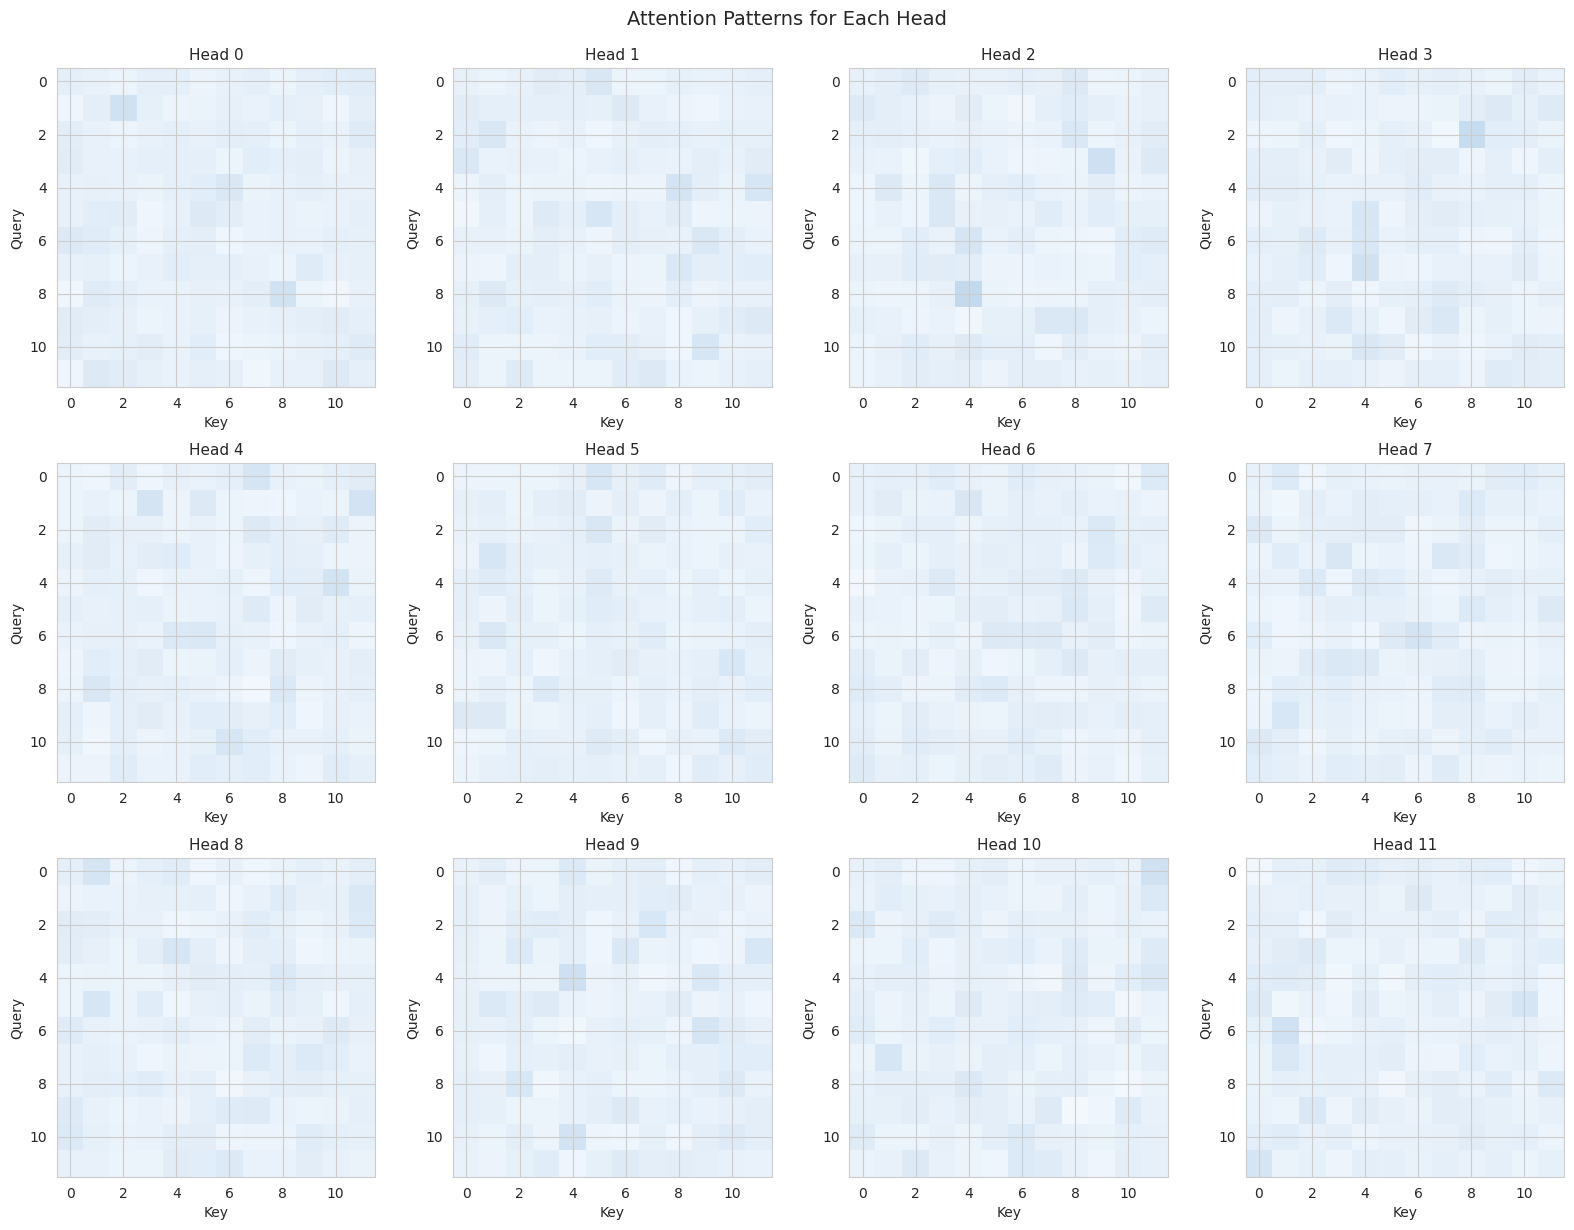

Notice: Different heads learn different attention patterns!


In [4]:
# Extract attention weights for each head
# We'll need to modify the forward pass temporarily to capture attention weights

class MultiHeadAttentionWithWeights(MultiHeadAttention):
    """Modified version that returns attention weights."""
    def forward(self, x):
        batch_size, seq_len, n_embd = x.size()
        
        # Project to Q, K, V
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        
        # Split into heads
        q = q.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        
        # Compute attention
        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        out = attn_weights @ v
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, n_embd)
        out = self.c_proj(out)
        out = self.resid_dropout(out)
        
        return out, attn_weights  # Also return weights

# Create modified version
mha_with_weights = MultiHeadAttentionWithWeights(n_embd=n_embd, n_head=n_head, dropout=0.0)
mha_with_weights.load_state_dict(mha.state_dict())  # Copy weights
mha_with_weights.eval()

# Generate sample input
seq_len = 12
x = torch.randn(1, seq_len, n_embd)

with torch.no_grad():
    output, attn_weights = mha_with_weights(x)

# attn_weights shape: (batch=1, n_head=12, seq_len=12, seq_len=12)
attn_weights = attn_weights.squeeze(0)  # Remove batch dimension

# Plot all 12 heads
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for head_idx in range(n_head):
    weights = attn_weights[head_idx].numpy()
    
    im = axes[head_idx].imshow(weights, cmap='Blues', vmin=0, vmax=1)
    axes[head_idx].set_title(f'Head {head_idx}', fontsize=11)
    axes[head_idx].set_xlabel('Key')
    axes[head_idx].set_ylabel('Query')

plt.tight_layout()
plt.suptitle('Attention Patterns for Each Head', y=1.02, fontsize=14)
plt.show()

print("Notice: Different heads learn different attention patterns!")

## Compare Single-Head vs Multi-Head

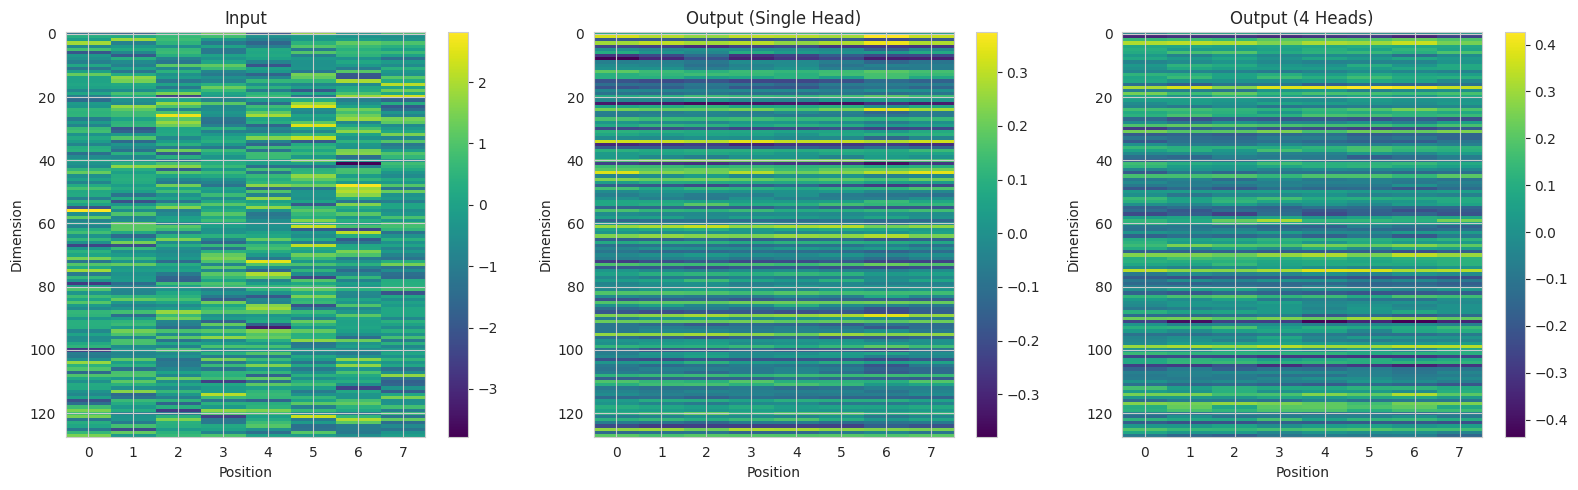

Multi-head attention creates richer representations!


In [5]:
# Create single-head and multi-head versions
n_embd_small = 128
seq_len = 8

single_head = MultiHeadAttention(n_embd=n_embd_small, n_head=1, dropout=0.0)
multi_head = MultiHeadAttention(n_embd=n_embd_small, n_head=4, dropout=0.0)

single_head.eval()
multi_head.eval()

x = torch.randn(1, seq_len, n_embd_small)

with torch.no_grad():
    out_single = single_head(x)
    out_multi = multi_head(x)

# Plot outputs
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

im0 = axes[0].imshow(x.squeeze().T.numpy(), aspect='auto', cmap='viridis')
axes[0].set_title('Input', fontsize=12)
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Dimension')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(out_single.squeeze().T.numpy(), aspect='auto', cmap='viridis')
axes[1].set_title('Output (Single Head)', fontsize=12)
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(out_multi.squeeze().T.numpy(), aspect='auto', cmap='viridis')
axes[2].set_title('Output (4 Heads)', fontsize=12)
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print("Multi-head attention creates richer representations!")

## Head Specialization Analysis

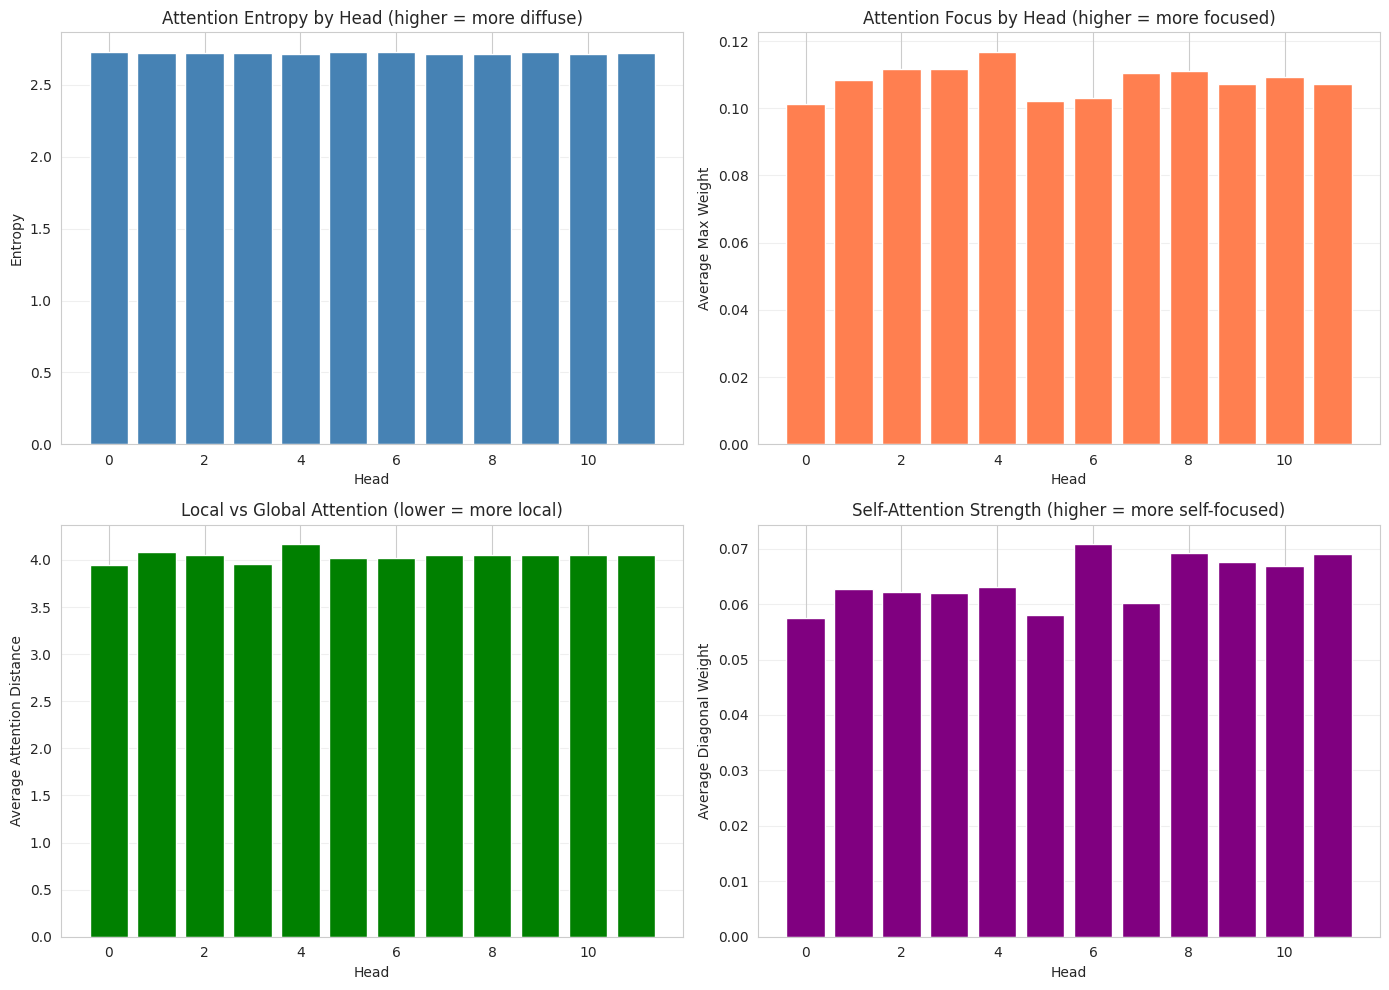

Different heads show different behaviors!
Some are local, some are global, some are diffuse, some are focused.


In [6]:
# Analyze what different heads might be learning
# We'll compute attention statistics for each head

seq_len = 16
x = torch.randn(1, seq_len, n_embd)

with torch.no_grad():
    _, attn_weights = mha_with_weights(x)

attn_weights = attn_weights.squeeze(0)  # (n_head, seq_len, seq_len)

# Compute statistics for each head
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Entropy (how diffuse is the attention?)
def entropy(probs):
    return -(probs * torch.log(probs + 1e-9)).sum(dim=-1).mean()

entropies = [entropy(attn_weights[h]).item() for h in range(n_head)]
axes[0, 0].bar(range(n_head), entropies, color='steelblue')
axes[0, 0].set_xlabel('Head')
axes[0, 0].set_ylabel('Entropy')
axes[0, 0].set_title('Attention Entropy by Head (higher = more diffuse)')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Max attention weight (how focused?)
max_weights = [attn_weights[h].max(dim=-1)[0].mean().item() for h in range(n_head)]
axes[0, 1].bar(range(n_head), max_weights, color='coral')
axes[0, 1].set_xlabel('Head')
axes[0, 1].set_ylabel('Average Max Weight')
axes[0, 1].set_title('Attention Focus by Head (higher = more focused)')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Local vs global attention (average attention distance)
def attention_distance(weights):
    """Compute average distance of attention."""
    positions = torch.arange(seq_len).float().view(1, -1)
    distances = []
    for i in range(seq_len):
        expected_pos = (weights[i] * positions).sum()
        dist = abs(expected_pos - i).item()
        distances.append(dist)
    return np.mean(distances)

distances = [attention_distance(attn_weights[h]) for h in range(n_head)]
axes[1, 0].bar(range(n_head), distances, color='green')
axes[1, 0].set_xlabel('Head')
axes[1, 0].set_ylabel('Average Attention Distance')
axes[1, 0].set_title('Local vs Global Attention (lower = more local)')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Diagonal dominance (self-attention strength)
diagonal_weights = [attn_weights[h].diag().mean().item() for h in range(n_head)]
axes[1, 1].bar(range(n_head), diagonal_weights, color='purple')
axes[1, 1].set_xlabel('Head')
axes[1, 1].set_ylabel('Average Diagonal Weight')
axes[1, 1].set_title('Self-Attention Strength (higher = more self-focused)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Different heads show different behaviors!")
print("Some are local, some are global, some are diffuse, some are focused.")

## Visualize Head Concatenation

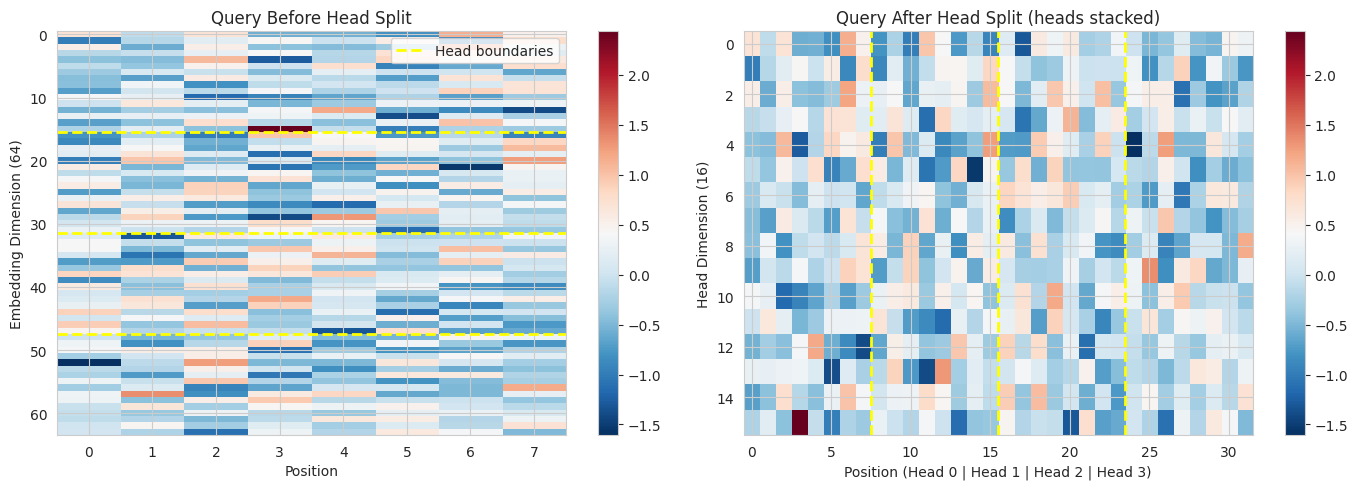

Embedding split: 64 dimensions → 4 heads × 16 dimensions


In [7]:
# Show how heads are split and concatenated
n_embd_vis = 64
n_head_vis = 4
seq_len = 8

mha_vis = MultiHeadAttentionWithWeights(n_embd=n_embd_vis, n_head=n_head_vis, dropout=0.0)
mha_vis.eval()

x = torch.randn(1, seq_len, n_embd_vis)

with torch.no_grad():
    # Get Q, K, V
    qkv = mha_vis.c_attn(x)
    q, k, v = qkv.split(n_embd_vis, dim=2)
    
    # Before splitting into heads
    q_before = q.squeeze()
    
    # After splitting into heads
    head_dim = n_embd_vis // n_head_vis
    q_heads = q.view(1, seq_len, n_head_vis, head_dim).transpose(1, 2).squeeze(0)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before split
im1 = axes[0].imshow(q_before.T.numpy(), aspect='auto', cmap='RdBu_r')
axes[0].set_title('Query Before Head Split', fontsize=12)
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Embedding Dimension (64)')
axes[0].axhline(y=15.5, color='yellow', linestyle='--', linewidth=2, label='Head boundaries')
axes[0].axhline(y=31.5, color='yellow', linestyle='--', linewidth=2)
axes[0].axhline(y=47.5, color='yellow', linestyle='--', linewidth=2)
axes[0].legend()
plt.colorbar(im1, ax=axes[0])

# After split (show all heads stacked)
q_heads_vis = q_heads.reshape(n_head_vis * seq_len, head_dim).T
im2 = axes[1].imshow(q_heads_vis.numpy(), aspect='auto', cmap='RdBu_r')
axes[1].set_title('Query After Head Split (heads stacked)', fontsize=12)
axes[1].set_xlabel('Position (Head 0 | Head 1 | Head 2 | Head 3)')
axes[1].set_ylabel('Head Dimension (16)')

# Add vertical lines to separate heads
for i in range(1, n_head_vis):
    axes[1].axvline(x=i*seq_len - 0.5, color='yellow', linestyle='--', linewidth=2)

plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Embedding split: {n_embd_vis} dimensions → {n_head_vis} heads × {head_dim} dimensions")

## Effect of Number of Heads

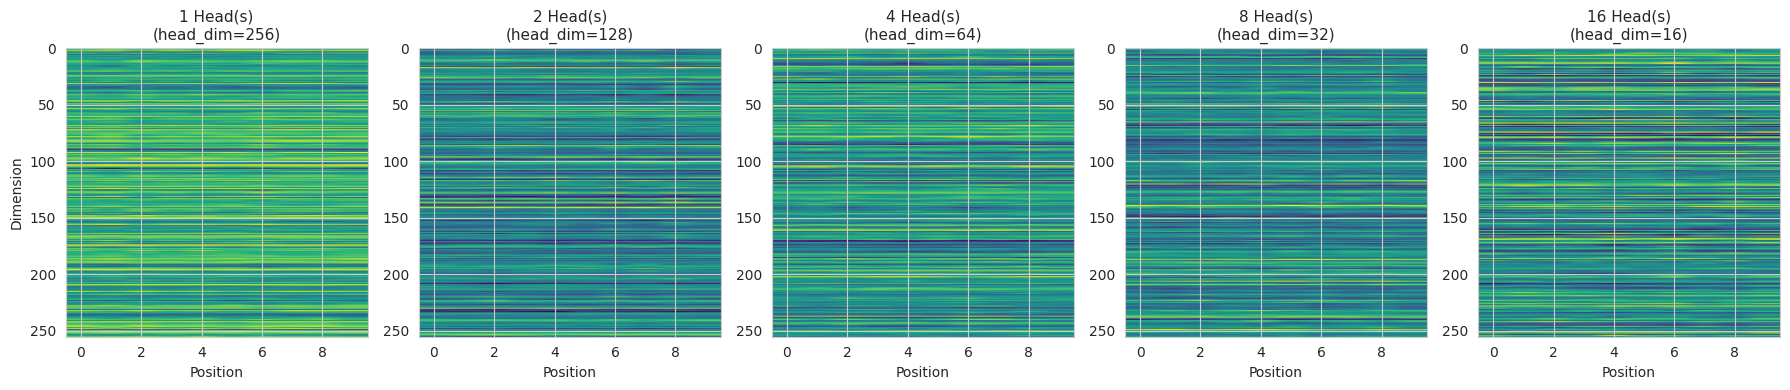

More heads allow the model to attend to different aspects simultaneously!


In [8]:
# Compare different numbers of heads
n_embd_test = 256
seq_len = 10
head_configs = [1, 2, 4, 8, 16]

x = torch.randn(1, seq_len, n_embd_test)

fig, axes = plt.subplots(1, len(head_configs), figsize=(18, 4))

for idx, n_heads in enumerate(head_configs):
    mha_test = MultiHeadAttention(n_embd=n_embd_test, n_head=n_heads, dropout=0.0)
    mha_test.eval()
    
    with torch.no_grad():
        output = mha_test(x)
    
    im = axes[idx].imshow(output.squeeze().T.numpy(), aspect='auto', cmap='viridis')
    axes[idx].set_title(f'{n_heads} Head(s)\n(head_dim={n_embd_test//n_heads})', fontsize=11)
    axes[idx].set_xlabel('Position')
    if idx == 0:
        axes[idx].set_ylabel('Dimension')

plt.tight_layout()
plt.show()

print("More heads allow the model to attend to different aspects simultaneously!")

## Parameter Count Comparison

Single head              : 2,362,368 parameters
2 heads                  : 2,362,368 parameters
4 heads                  : 2,362,368 parameters
6 heads                  : 2,362,368 parameters
12 heads (GPT-2)         : 2,362,368 parameters


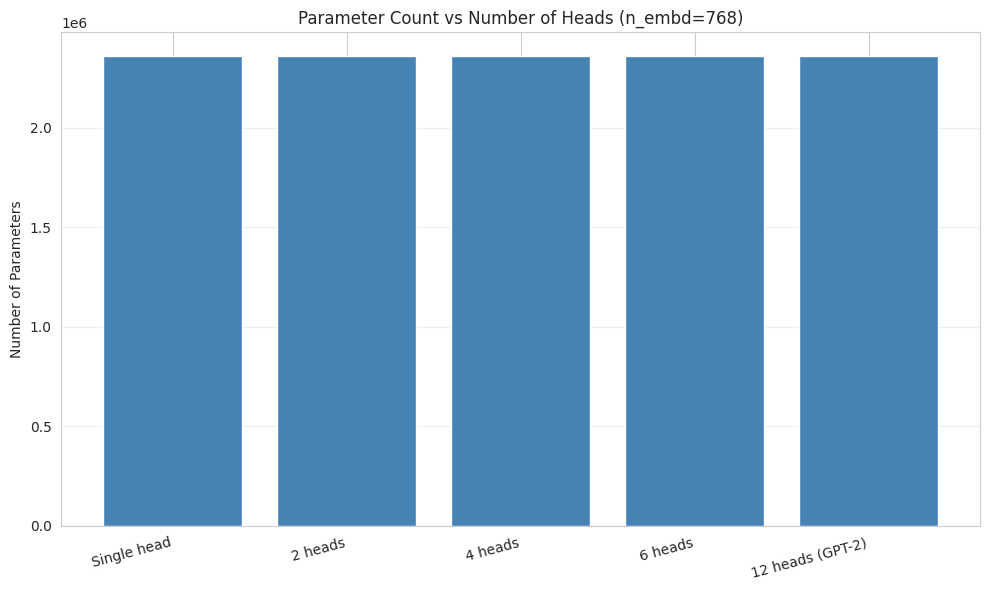


Note: Parameter count is the SAME regardless of number of heads!
Multi-head attention doesn't add parameters, it splits computation.


In [9]:
# Compare parameter counts
configs = [
    (768, 1, "Single head"),
    (768, 2, "2 heads"),
    (768, 4, "4 heads"),
    (768, 6, "6 heads"),
    (768, 12, "12 heads (GPT-2)"),
]

param_counts = []
labels = []

for n_embd, n_head, label in configs:
    mha = MultiHeadAttention(n_embd=n_embd, n_head=n_head)
    params = sum(p.numel() for p in mha.parameters())
    param_counts.append(params)
    labels.append(label)
    print(f"{label:25s}: {params:,} parameters")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(labels)), param_counts, color='steelblue')
plt.xticks(range(len(labels)), labels, rotation=15, ha='right')
plt.ylabel('Number of Parameters')
plt.title('Parameter Count vs Number of Heads (n_embd=768)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Parameter count is the SAME regardless of number of heads!")
print("Multi-head attention doesn't add parameters, it splits computation.")

## Verify Your Implementation

In [10]:
# Quick verification
mha = MultiHeadAttention(n_embd=768, n_head=12, dropout=0.1)
x = torch.randn(2, 10, 768)
output = mha(x)

print("✓ Module initializes correctly")
print(f"✓ Forward pass works: {x.shape} → {output.shape}")
print(f"✓ Shape preserved: {x.shape == output.shape}")
print(f"✓ Head dimension: {mha.head_dim} = {768//12}")
print("\n✅ Basic functionality verified!")
print("\nRun 'uv run pytest test_multi_head_attention.py -v' for complete validation.")

✓ Module initializes correctly
✓ Forward pass works: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])
✓ Shape preserved: True
✓ Head dimension: 64 = 64

✅ Basic functionality verified!

Run 'uv run pytest test_multi_head_attention.py -v' for complete validation.
